In [ ]:
from SignalMasterABC import SignalMaster
from modules import TradingBook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

do_print = True
TRADINGBEGIN = '2001'
# Each class needs to re-read the


class MaPenetration(SignalMaster):

    def __init__(self, first_rolling, second_rolling, third_rolling, atr_stop_loss, entry_atr=0):
        super().__init__()
        self.first_rolling = first_rolling
        self.second_rolling = second_rolling
        self.third_rolling = third_rolling
        self.atr_stop_loss = atr_stop_loss
        self.entry_atr = entry_atr
        self.trade_checking_df = pd.DataFrame()
        self.recap_arr = []
        self.my_date_list = []
        self.no_trade_ratio = 1  # This is 20/50 MA filter. 1 means no filter is applied
        self.signal_df = None

    def hull_moving_average(self, window_size):
        signal_df = self.df2m.copy()
        weighted_moving_average = 2 * signal_df['Close'].rolling(window_size//2).mean() - signal_df['Close'].rolling(window_size).mean()
        hull_moving_average = weighted_moving_average.rolling(int(window_size**0.5)).mean()
        return hull_moving_average

    def triple_exponential_moving_average(self, window_size):
         signal_df = self.df2m.copy()
         ema1 = signal_df['Close'].ewm(window_size).mean()
         ema2 = ema1.ewm(window_size).mean()
         ema3 = ema2.ewm(window_size).mean()
    
         tema = 3 * ema1 - 3 * ema2 + ema3
    
         return tema
    
    def get_signal_df(self):

        signal_df = self.df2m.copy()
        tema1 = self.triple_exponential_moving_average(self.first_rolling)
        tema2 = self.triple_exponential_moving_average(self.second_rolling)
        tema3 = self.triple_exponential_moving_average(self.third_rolling)
        hma = self.hull_moving_average(self.third_rolling)
        signal_df['rolling_ma_first'] = signal_df['Close'].rolling(self.first_rolling).mean()
        signal_df['rolling_tema_first'] = tema1
        signal_df['rolling_ma_second'] = signal_df['Close'].rolling(self.second_rolling).mean()
        signal_df['rolling_tema_second'] = tema2
        signal_df['rolling_tema_third'] = hma
        signal_df['rolling_sum_first_minus1'] = signal_df['Close'].rolling(self.first_rolling - 1).sum().shift()
        signal_df['rolling_sum_second_minus1'] = signal_df['Close'].rolling(self.second_rolling - 1).sum().shift()
        signal_df['high_previous'] = signal_df['High'].shift(3)
        signal_df['low_previous'] = signal_df['Low'].shift(3)

        # The identifier should use shift as we do not know the close price
        signal_df['rolling_ma_20'] = signal_df['Close'].shift().rolling(20).mean()
        signal_df['rolling_ma_50'] = signal_df['Close'].shift().rolling(50).mean()

        signal_df['rolling_gap'] = (signal_df['rolling_tema_first'] - signal_df['rolling_tema_second'])
        signal_df['TradingVol'] = (100 / self.ser_atr).fillna(0).astype(int)
        signal_df = signal_df.dropna()

        signal_df['previous_gap'] = signal_df['rolling_gap'].shift(1)
        signal_df['forward_gap'] = signal_df['rolling_gap'].shift(-1)
        signal_df['crossing'] = (signal_df['rolling_gap'] * signal_df['previous_gap']) < 0
        signal_df['cross_signal'] = np.sign(signal_df['rolling_gap'])

        signal_df['target_open_price'] = ((signal_df['rolling_sum_second_minus1'] * self.first_rolling -
                                           signal_df['rolling_sum_first_minus1'] * self.second_rolling) /
                                          (self.second_rolling - self.first_rolling))
        
        signal_df['target_open_price'] = ((signal_df['rolling_sum_second_minus1'] * self.first_rolling -
                                           signal_df['rolling_sum_first_minus1'] * self.second_rolling) /
                                          (self.second_rolling - self.first_rolling))

        signal_df['target_open_price'] = (signal_df['target_open_price'] +
                                          self.ser_atr.loc[signal_df.index] *
                                          self.entry_atr * np.where(signal_df['previous_gap'] > 0, -1, 1)).round(2)
        self.signal_df = signal_df

    def signal_execution_backtesting(self):

        if self.signal_df is None:
            self.get_signal_df()

        my_book = TradingBook()

        for my_date, row_ind in self.signal_df.loc[TRADINGBEGIN:].iterrows():

            # Trade Size
            t_size = row_ind['TradingVol']
            if do_print:
                print('-' * 55)
                print(my_date)

            self.trade_checking_df.loc[my_date, 'rolling_gap'] = row_ind['rolling_gap']
            self.trade_checking_df.loc[my_date, 'previous_gap'] = row_ind['previous_gap']
            self.trade_checking_df.loc[my_date, 'Open'] = row_ind['Open']
            self.trade_checking_df.loc[my_date, 'High'] = row_ind['High']
            self.trade_checking_df.loc[my_date, 'Low'] = row_ind['Low']

            row_m2 = self.df2m.loc[my_date]
            i_atr = self.ser_atr.loc[my_date]

            if row_m2.isna().any():
                continue

            my_position = my_book.position('FP')
            self.trade_checking_df.loc[my_date, 'open_position'] = my_position
            if my_position != 0:
                position_price = my_book.get_avg_open_price('FP')
                self.trade_checking_df.loc[my_date, 'open_position_price'] = position_price
            trade_price = np.NaN
            # short open
            if row_ind['rolling_tema_third']> row_ind['rolling_tema_second'] and row_ind['rolling_tema_third']> row_ind['rolling_tema_first']:
                if row_ind['forward_gap'] < 0 and row_ind['rolling_gap'] >= 0:
                    trade_price = row_ind['Close']
                
                if not np.isnan(trade_price):
                    target_trade = -t_size

                    # if row_ind['rolling_ma_20'] >= row_ind['rolling_ma_50']:
                    #     target_trade *= self.no_trade_ratio
                    trading_vol = target_trade - my_position
                    if trading_vol != 0:
                        my_book.trade(my_date, 'FP', trading_vol, trade_price, self.contract_size)
                        self.trade_checking_df.loc[my_date, 'trade_price'] = trade_price
                        self.trade_checking_df.loc[my_date, 'trade_vol'] = trading_vol
                        self.trade_checking_df.loc[my_date, 'checktrade'] = 1
                        if do_print:
                            print('-' * 55)
                            print("Trade {} at {}".format(trading_vol, trade_price))

             # long open        
            elif row_ind['rolling_tema_third']< row_ind['rolling_tema_second'] and row_ind['rolling_tema_third']< row_ind['rolling_tema_first']:
                if row_ind['forward_gap'] > 0 and row_ind['rolling_gap'] <= 0:
                    trade_price = row_ind['Close']

                if not np.isnan(trade_price):
                    target_trade = t_size
                    print(t_size)

                    # if row_ind['rolling_ma_20'] >= row_ind['rolling_ma_50']:
                    #     target_trade *= self.no_trade_ratio
                    trading_vol = target_trade - my_position
                    if trading_vol != 0:
                        my_book.trade(my_date, 'FP', trading_vol, trade_price, self.contract_size)
                        self.trade_checking_df.loc[my_date, 'trade_price'] = trade_price
                        self.trade_checking_df.loc[my_date, 'trade_vol'] = trading_vol
                        self.trade_checking_df.loc[my_date, 'checktrade'] = 1
                        if do_print:
                            print('-' * 55)
                            print("Trade {} at {}".format(trading_vol, trade_price))

            # short close
            elif row_ind['rolling_tema_third']> row_ind['rolling_tema_second'] and row_ind['rolling_tema_third']> row_ind['rolling_tema_first']:
                if row_ind['rolling_gap'] < 0 and row_ind['forward_gap'] >= 0:
                    trade_price = row_ind['Close']


                    trading_vol = - my_position

                    if trading_vol != 0:
                        my_book.trade(my_date, 'FP', trading_vol, trade_price, self.contract_size)
                        self.trade_checking_df.loc[my_date, 'trade_price'] = trade_price
                        self.trade_checking_df.loc[my_date, 'trade_vol'] = trading_vol
                        self.trade_checking_df.loc[my_date, 'checktrade'] = 1
                        my_position = 0
                        if do_print:
                            print('-' * 55)
                            print("Trade {} at {}".format(trading_vol, trade_price))
            # long close
            elif row_ind['rolling_tema_third']< row_ind['rolling_tema_second'] and row_ind['rolling_tema_third']< row_ind['rolling_tema_first']:
                if row_ind['rolling_gap'] > 0 and row_ind['forward_gap'] <= 0:
                    trade_price = row_ind['Close']

                    trading_vol = - my_position

                    if trading_vol != 0:
                        my_book.trade(my_date, 'FP', trading_vol, trade_price, self.contract_size)
                        self.trade_checking_df.loc[my_date, 'trade_price'] = trade_price
                        self.trade_checking_df.loc[my_date, 'trade_vol'] = trading_vol
                        self.trade_checking_df.loc[my_date, 'checktrade'] = 1
                        my_position = 0
                        if do_print:
                            print('-' * 55)
                            print("Trade {} at {}".format(trading_vol, trade_price))

            my_position = my_book.position('FP')
            # Now the stop loss
            if my_position < 0:
                position_price = my_book.get_avg_open_price('FP')
                stop_loss_target = np.round(position_price + self.atr_stop_loss * i_atr, 2)
                # Stop loss
                if row_m2['High'] > stop_loss_target:
                    my_book.trade(my_date, 'FP', -my_position, stop_loss_target, self.contract_size)
                    self.trade_checking_df.loc[my_date, 'stop_price_short'] = stop_loss_target
                    self.trade_checking_df.loc[my_date, 'stop_cost_short'] = position_price
                    self.trade_checking_df.loc[my_date, 'stop_atr_short'] = self.atr_stop_loss * i_atr
                    self.trade_checking_df.loc[my_date, 'trade_vol_stop'] = my_position
                    self.trade_checking_df.loc[my_date, 'checktrade'] = 1
                    my_position = 0
                    if do_print:
                        print('-' * 55)
                        print("Short Stop Loss, {} at ATR Loss {}".format(stop_loss_target, self.atr_stop_loss * i_atr))
            elif my_position > 0:
                position_price = my_book.get_avg_open_price('FP')
                stop_loss_target = np.round(position_price - self.atr_stop_loss * i_atr, 2)
                # Stop loss
                if row_m2['Low'] < stop_loss_target:
                    my_book.trade(my_date, 'FP', -my_position, stop_loss_target, self.contract_size)
                    self.trade_checking_df.loc[my_date, 'stop_price_long'] = stop_loss_target
                    self.trade_checking_df.loc[my_date, 'stop_cost_long'] = position_price
                    self.trade_checking_df.loc[my_date, 'stop_atr_long'] = self.atr_stop_loss * i_atr
                    self.trade_checking_df.loc[my_date, 'trade_vol_stop'] = -my_position
                    self.trade_checking_df.loc[my_date, 'checktrade'] = 1
                    my_position = 0
                    if do_print:
                        print('-' * 55)
                        print("Long Stop Loss, {} at ATR Loss {}".format(stop_loss_target, self.atr_stop_loss * i_atr))
            

            # Now the reduction in position
            # my_position = my_book.position('FP')
            # if my_position < 0 and row_ind['Open'] > row_ind['high_previous']:
            #     trade_price = row_ind['Open']
            #     print(my_position, trade_price)
            #     my_positions = my_position*0.10

            #     if trading_vol != 0:
            #         my_book.trade(my_date, 'FP', -my_positions, trade_price, self.contract_size)
            #         self.trade_checking_df.loc[my_date, 'trade_price'] = trade_price
            #         self.trade_checking_df.loc[my_date, 'trade_vol'] = trading_vol
            #         self.trade_checking_df.loc[my_date, 'checktrade'] = 1
            #         if do_print:
            #             print('-' * 55)
            #             print("Reduce {} at {}".format(my_position, trade_price))

            # elif my_position > 0 and row_ind['Open'] < row_ind['low_previous']:
            #     trade_price = row_ind['Open']
            #     print(my_position, trade_price)
            #     my_positions = my_position*0.10

            #     if trading_vol != 0:
            #         my_book.trade(my_date, 'FP', -my_positions, trade_price, self.contract_size)
            #         self.trade_checking_df.loc[my_date, 'trade_price'] = trade_price
            #         self.trade_checking_df.loc[my_date, 'trade_vol'] = trading_vol
            #         self.trade_checking_df.loc[my_date, 'checktrade'] = 1
            #         if do_print:
            #             print('-' * 55)
            #             print("Reduce {} at {}".format(my_position, trade_price))

            # Now the reduction in position
            my_position = my_book.position('FP')
            if my_position < 0 and row_ind['Open'] > row_ind['high_previous']:
                trade_price = row_ind['Open']
                print(my_position, trade_price)
                my_positions = my_position*0.10

                if trading_vol != 0:
                    my_book.trade(my_date, 'FP', -my_positions, trade_price, self.contract_size)
                    self.trade_checking_df.loc[my_date, 'trade_price'] = trade_price
                    self.trade_checking_df.loc[my_date, 'trade_vol'] = trading_vol
                    self.trade_checking_df.loc[my_date, 'checktrade'] = 1
                    if do_print:
                        print('-' * 55)
                        print("Reduce {} at {}".format(my_position, trade_price))

            # Rolling logic
            if my_position != 0:
                position_rolled = self.check_rolling(my_date, my_book)
                if position_rolled and do_print:
                    _position_price = my_book.get_avg_open_price('FP')
                    print('-' * 55)
                    print("position price has been changed from {} to {}".format(trade_price, _position_price))

            pos_fp = my_book.position('FP')
            total_pnl = my_book.total_pnl('FP', row_m2['Close'], self.contract_size)

            recap_row = {}
            recap_row['FP Price'] = row_m2['Close']
            recap_row['FP Pos'] = pos_fp
            recap_row['P&L'] = total_pnl

            # Index
            self.my_date_list.append(my_date)
            self.recap_arr.append(recap_row)

        df_book = pd.DataFrame(self.recap_arr)
        df_book.index = self.my_date_list
        
        # return self.trade_checking_df
        return df_book, self.trade_checking_df, self.signal_df

In [ ]:
price = MaPenetration(7, 31, 80, 1.7).signal_execution_backtesting()

c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


-------------------------------------------------------
2001-01-02 00:00:00
-------------------------------------------------------
2001-01-03 00:00:00
-------------------------------------------------------
2001-01-04 00:00:00
-------------------------------------------------------
2001-01-05 00:00:00
-------------------------------------------------------
2001-01-08 00:00:00
-------------------------------------------------------
2001-01-09 00:00:00
-------------------------------------------------------
2001-01-10 00:00:00
-------------------------------------------------------
2001-01-11 00:00:00
-------------------------------------------------------
2001-01-12 00:00:00
-------------------------------------------------------
2001-01-16 00:00:00
-------------------------------------------------------
2001-01-17 00:00:00
-------------------------------------------------------
2001-01-18 00:00:00
-------------------------------------------------------
2001-01-19 00:00:00
------------

<AxesSubplot:>

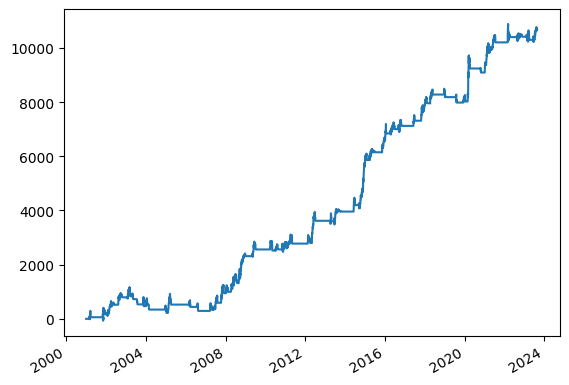

In [89]:
price[0]['P&L'].plot()

In [79]:
import numpy as np

def sharpe_ratio(time_series_returns, risk_free_rate):
    """
    Calculate the Sharpe Ratio of a given time series of returns.

    Parameters:
    time_series_returns (array-like): Time series of returns.
    risk_free_rate (float): The annual risk-free rate of return.

    Returns:
    float: The Sharpe Ratio.
    """
    average_return = np.mean(time_series_returns)
    std_deviation = np.std(time_series_returns)
    sharpe = (average_return - risk_free_rate) / std_deviation
    return sharpe

# Example usage:
# time_series_returns = [0.05, 0.03, 0.02, 0.04, 0.06]  # Example time series of returns
# Example time series of returns (replace this with your own time series data)
# time_series_returns = np.random.normal(loc=0.05, scale=0.1, size=100)  
risk_free_rate = 0.02  # Example risk-free rate (annualized)
# sharpe = sharpe_ratio(time_series_returns, risk_free_rate)
# print("Sharpe Ratio:", sharpe)

In [75]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf =0.01 #1% risk free rate
sharpes = sharpe_ratio(hh, N, rf)

In [76]:
sharpes

19.068723013410008

In [85]:
ratio = sharpe_ratio(hh, risk_free_rate)

In [86]:
ratio

1.2034355575123468

In [90]:
dd = pd.read_pickle('rolling_dates.pickle')

In [91]:
dd

,CO,CL,QS,HO,XB
2000-01-01,1999-12-16,1999-12-20,2000-01-12,1999-12-30,NaN
2000-02-01,2000-01-14,2000-01-20,2000-02-10,2000-01-31,NaN
2000-03-01,2000-02-14,2000-02-22,2000-03-10,2000-02-29,NaN
2000-04-01,2000-03-16,2000-03-21,2000-04-12,2000-03-31,NaN
2000-05-01,2000-04-13,2000-04-19,2000-05-11,2000-04-28,NaN
...,...,...,...,...,...
2028-11-01,2028-09-29,2028-10-20,2028-11-10,NaN,NaN
2028-12-01,2028-10-31,2028-11-20,2028-12-12,NaN,NaN
2029-01-01,2028-11-30,2028-12-19,2029-01-11,NaN,NaN
2029-02-01,2028-12-28,2029-01-22,2029-02-12,NaN,NaN


In [47]:
for i in range(6,11):
    for j in range(26,32):
            price = MaPenetration(i, j, 80, 2).signal_execution_backtesting()
            print(price[0])

c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


114
104
114
126
101
101
74
64
57
63
64
50
26
31
19
18
37
41
42
36
53
52
42
47
50
26
34
48
92
46
55
61
59
55
61
59
100
87
66
70
79
57
64
56
68
72
50
44
50
26
11
24
38
42
38
            FP Price  FP Pos      P&L
2001-01-02     26.52       0     0.00
2001-01-03     27.27       0     0.00
2001-01-04     27.54       0     0.00
2001-01-05     27.16       0     0.00
2001-01-08     26.51       0     0.00
...              ...     ...      ...
2023-08-15     80.50      38  7248.82
2023-08-16     79.02      38  7192.58
2023-08-17     79.90      38  7226.02
2023-08-18     80.66      38  7254.90
2023-08-21     81.14      38  7273.14

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


126
114
104
114
126
101
101
71
57
63
65
50
26
31
19
18
37
34
41
42
36
53
51
42
47
50
26
34
52
48
92
46
61
55
61
59
100
87
66
70
80
57
62
56
68
72
50
44
50
26
11
24
38
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  7731.929
2023-08-16     79.02      38  7675.689
2023-08-17     79.90      38  7709.129
2023-08-18     80.66      38  7738.009
2023-08-21     81.14      38  7756.249

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


126
108
104
114
126
101
101
71
57
63
65
50
26
31
20
18
36
41
42
36
51
51
42
47
50
26
34
33
52
48
92
46
61
55
61
59
100
87
66
80
57
62
56
68
72
50
44
50
26
11
24
38
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  9055.984
2023-08-16     79.02      38  8999.744
2023-08-17     79.90      38  9033.184
2023-08-18     80.66      38  9062.064
2023-08-21     81.14      38  9080.304

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


128
108
104
113
126
101
71
57
63
65
50
26
31
20
18
36
41
36
51
51
42
45
47
50
26
34
33
52
48
92
46
61
55
61
59
100
87
66
84
57
62
56
68
71
50
50
26
11
24
38
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0      0.00
2001-01-03     27.27       0      0.00
2001-01-04     27.54       0      0.00
2001-01-05     27.16       0      0.00
2001-01-08     26.51       0      0.00
...              ...     ...       ...
2023-08-15     80.50      38  10395.75
2023-08-16     79.02      38  10339.51
2023-08-17     79.90      38  10372.95
2023-08-18     80.66      38  10401.83
2023-08-21     81.14      38  10420.07

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


128
108
99
112
113
126
101
71
57
63
65
50
26
31
20
18
41
51
51
42
46
50
26
33
38
48
92
46
42
61
54
61
59
96
87
66
84
57
62
56
68
71
50
50
26
11
24
38
38
            FP Price  FP Pos        P&L
2001-01-02     26.52       0      0.000
2001-01-03     27.27       0      0.000
2001-01-04     27.54       0      0.000
2001-01-05     27.16       0      0.000
2001-01-08     26.51       0      0.000
...              ...     ...        ...
2023-08-15     80.50      38  10936.983
2023-08-16     79.02      38  10880.743
2023-08-17     79.90      38  10914.183
2023-08-18     80.66      38  10943.063
2023-08-21     81.14      38  10961.303

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


128
108
86
96
113
126
101
72
62
57
63
50
26
31
20
18
40
51
51
42
46
50
26
33
38
48
92
46
42
61
54
61
61
59
94
96
87
66
85
57
62
61
56
72
71
50
50
26
11
24
38
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0      0.00
2001-01-03     27.27       0      0.00
2001-01-04     27.54       0      0.00
2001-01-05     27.16       0      0.00
2001-01-08     26.51       0      0.00
...              ...     ...       ...
2023-08-15     80.50      38  11297.53
2023-08-16     79.02      38  11241.29
2023-08-17     79.90      38  11274.73
2023-08-18     80.66      38  11303.61
2023-08-21     81.14      38  11321.85

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


114
117
105
114
126
101
101
71
56
57
63
65
50
26
31
19
18
37
42
36
53
52
42
47
50
26
34
48
92
47
56
61
59
56
59
81
100
87
66
70
79
57
64
68
72
50
44
50
26
24
38
42
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50       0  7991.445
2023-08-16     79.02       0  7991.445
2023-08-17     79.90       0  7991.445
2023-08-18     80.66       0  7991.445
2023-08-21     81.14       0  7991.445

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


114
104
114
126
101
71
56
57
63
50
26
31
19
18
37
42
36
51
52
42
45
47
50
26
34
33
34
48
92
46
55
61
59
55
59
81
100
87
66
80
57
62
68
72
50
44
50
26
11
24
38
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  9867.168
2023-08-16     79.02      38  9810.928
2023-08-17     79.90      38  9844.368
2023-08-18     80.66      38  9873.248
2023-08-21     81.14      38  9891.488

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


108
104
112
113
126
101
72
56
57
63
50
26
31
19
18
36
42
36
51
52
42
47
50
26
34
52
48
92
46
61
55
59
100
87
66
80
57
62
68
72
50
44
50
26
11
24
38
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  8987.452
2023-08-16     79.02      38  8931.212
2023-08-17     79.90      38  8964.652
2023-08-18     80.66      38  8993.532
2023-08-21     81.14      38  9011.772

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


126
108
104
113
126
101
72
56
57
63
50
26
31
19
18
36
41
36
51
51
42
47
50
26
34
52
48
92
46
61
55
59
100
87
66
84
57
62
68
72
50
50
26
11
24
38
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  8796.564
2023-08-16     79.02      38  8740.324
2023-08-17     79.90      38  8773.764
2023-08-18     80.66      38  8802.644
2023-08-21     81.14      38  8820.884

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


126
108
138
86
104
113
126
101
72
57
63
50
26
31
19
18
35
41
51
51
42
46
50
24
33
48
92
46
61
55
59
100
87
66
85
57
62
68
72
50
50
26
11
24
38
42
38
            FP Price  FP Pos        P&L
2001-01-02     26.52       0      0.000
2001-01-03     27.27       0      0.000
2001-01-04     27.54       0      0.000
2001-01-05     27.16       0      0.000
2001-01-08     26.51       0      0.000
...              ...     ...        ...
2023-08-15     80.50      38  11668.276
2023-08-16     79.02      38  11612.036
2023-08-17     79.90      38  11645.476
2023-08-18     80.66      38  11674.356
2023-08-21     81.14      38  11692.596

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


128
108
138
86
96
126
101
72
62
57
63
63
50
26
31
19
18
41
51
51
42
46
50
24
33
45
48
92
46
61
54
61
62
59
96
90
66
57
62
61
72
72
50
51
26
11
24
38
42
38
            FP Price  FP Pos        P&L
2001-01-02     26.52       0      0.000
2001-01-03     27.27       0      0.000
2001-01-04     27.54       0      0.000
2001-01-05     27.16       0      0.000
2001-01-08     26.51       0      0.000
...              ...     ...        ...
2023-08-15     80.50      38  11593.768
2023-08-16     79.02      38  11537.528
2023-08-17     79.90      38  11570.968
2023-08-18     80.66      38  11599.848
2023-08-21     81.14      38  11618.088

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


114
117
105
114
126
101
72
57
63
50
26
31
18
37
42
42
36
51
52
47
50
24
34
48
92
47
56
61
59
59
81
100
87
70
79
56
62
68
72
50
44
50
26
38
42
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50       0  8266.802
2023-08-16     79.02       0  8266.802
2023-08-17     79.90       0  8266.802
2023-08-18     80.66       0  8266.802
2023-08-21     81.14       0  8266.802

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


114
104
114
126
101
57
63
50
26
31
19
18
37
42
42
36
51
52
47
50
24
34
48
92
46
55
61
59
56
59
81
81
100
87
66
80
56
62
68
72
50
44
50
26
38
42
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50       0  7190.282
2023-08-16     79.02       0  7190.282
2023-08-17     79.90       0  7190.282
2023-08-18     80.66       0  7190.282
2023-08-21     81.14       0  7190.282

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


108
138
104
113
126
101
57
63
50
26
31
19
18
36
42
36
51
52
47
50
34
45
52
48
92
46
61
55
59
81
100
87
66
80
84
56
62
68
72
50
50
26
11
38
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  9170.808
2023-08-16     79.02      38  9114.568
2023-08-17     79.90      38  9148.008
2023-08-18     80.66      38  9176.888
2023-08-21     81.14      38  9195.128

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


108
138
104
126
101
57
63
63
50
26
31
19
18
35
42
36
51
46
50
33
45
52
48
92
46
61
55
59
81
100
90
66
84
57
62
72
72
50
50
26
11
38
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  9906.778
2023-08-16     79.02      38  9850.538
2023-08-17     79.90      38  9883.978
2023-08-18     80.66      38  9912.858
2023-08-21     81.14      38  9931.098

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


126
108
138
86
104
126
101
81
57
63
63
50
26
32
19
18
42
51
46
33
45
48
81
92
46
61
55
59
80
100
90
66
57
65
61
54
72
72
50
50
26
11
38
42
38
            FP Price  FP Pos        P&L
2001-01-02     26.52       0      0.000
2001-01-03     27.27       0      0.000
2001-01-04     27.54       0      0.000
2001-01-05     27.16       0      0.000
2001-01-08     26.51       0      0.000
...              ...     ...        ...
2023-08-15     80.50      38  11082.933
2023-08-16     79.02      38  11026.693
2023-08-17     79.90      38  11060.133
2023-08-18     80.66      38  11089.013
2023-08-21     81.14      38  11107.253

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


128
109
138
96
126
81
62
57
63
63
50
26
32
19
18
42
51
48
45
44
48
81
92
46
61
54
61
59
100
90
66
57
65
65
54
72
72
50
51
28
11
37
42
38
            FP Price  FP Pos        P&L
2001-01-02     26.52       0      0.000
2001-01-03     27.27       0      0.000
2001-01-04     27.54       0      0.000
2001-01-05     27.16       0      0.000
2001-01-08     26.51       0      0.000
...              ...     ...        ...
2023-08-15     80.50      38  11235.681
2023-08-16     79.02      38  11179.441
2023-08-17     79.90      38  11212.881
2023-08-18     80.66      38  11241.761
2023-08-21     81.14      38  11260.001

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


114
138
105
113
126
101
56
57
63
50
26
31
18
37
42
42
35
52
47
50
34
48
92
47
56
61
59
59
100
87
79
62
68
71
50
44
50
26
38
42
            FP Price  FP Pos      P&L
2001-01-02     26.52       0     0.00
2001-01-03     27.27       0     0.00
2001-01-04     27.54       0     0.00
2001-01-05     27.16       0     0.00
2001-01-08     26.51       0     0.00
...              ...     ...      ...
2023-08-15     80.50       0  6844.05
2023-08-16     79.02       0  6844.05
2023-08-17     79.90       0  6844.05
2023-08-18     80.66       0  6844.05
2023-08-21     81.14       0  6844.05

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


108
138
105
113
126
101
81
56
57
63
50
26
31
18
37
42
42
36
52
47
50
33
48
92
46
61
59
59
81
100
87
80
62
68
71
50
50
26
38
42
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50       0  6950.588
2023-08-16     79.02       0  6950.588
2023-08-17     79.90       0  6950.588
2023-08-18     80.66       0  6950.588
2023-08-21     81.14       0  6950.588

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


108
138
104
126
81
56
57
63
63
50
26
32
18
36
42
42
36
52
46
50
52
44
48
92
46
61
60
56
59
81
81
100
90
80
84
65
72
72
50
50
26
11
38
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  9500.087
2023-08-16     79.02      38  9443.847
2023-08-17     79.90      38  9477.287
2023-08-18     80.66      38  9506.167
2023-08-21     81.14      38  9524.407

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


126
109
138
83
104
126
81
57
63
63
50
26
32
19
18
42
42
36
51
48
44
48
92
46
61
55
59
81
100
90
85
65
61
54
72
72
50
50
28
11
37
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0      0.00
2001-01-03     27.27       0      0.00
2001-01-04     27.54       0      0.00
2001-01-05     27.16       0      0.00
2001-01-08     26.51       0      0.00
...              ...     ...       ...
2023-08-15     80.50      38  10462.41
2023-08-16     79.02      38  10406.17
2023-08-17     79.90      38  10439.61
2023-08-18     80.66      38  10468.49
2023-08-21     81.14      38  10486.73

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


126
109
138
99
126
81
62
57
63
63
52
26
32
19
18
42
51
46
44
48
92
46
61
55
59
81
100
66
65
65
54
72
50
50
11
37
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  7417.732
2023-08-16     79.02      38  7361.492
2023-08-17     79.90      38  7394.932
2023-08-18     80.66      38  7423.812
2023-08-21     81.14      38  7442.052

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


128
138
126
81
63
57
63
63
52
26
32
19
18
42
54
51
46
44
44
48
92
47
61
55
61
59
100
66
56
65
65
54
72
50
51
11
37
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  6670.517
2023-08-16     79.02      38  6614.277
2023-08-17     79.90      38  6647.717
2023-08-18     80.66      38  6676.597
2023-08-21     81.14      38  6694.837

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


108
138
105
126
81
57
63
52
26
32
18
37
43
42
35
52
47
50
48
47
55
61
59
60
100
90
79
65
72
71
50
44
49
26
38
40
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50       0  7244.966
2023-08-16     79.02       0  7244.966
2023-08-17     79.90       0  7244.966
2023-08-18     80.66       0  7244.966
2023-08-21     81.14       0  7244.966

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


109
138
104
126
81
57
63
63
52
26
32
18
36
43
42
36
52
46
50
48
92
46
55
61
59
60
59
100
90
80
65
72
71
50
50
26
11
38
42
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50       0  8851.511
2023-08-16     79.02       0  8851.511
2023-08-17     79.90       0  8851.511
2023-08-18     80.66       0  8851.511
2023-08-21     81.14       0  8851.511

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


126
138
104
126
81
57
63
63
52
26
32
18
43
42
36
52
50
46
48
92
46
54
61
56
59
81
100
84
65
54
71
50
50
28
11
37
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  7530.312
2023-08-16     79.02      38  7474.072
2023-08-17     79.90      38  7507.512
2023-08-18     80.66      38  7536.392
2023-08-21     81.14      38  7554.632

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


128
138
104
126
81
62
57
63
63
52
26
26
32
19
18
42
42
36
51
46
44
48
84
92
46
57
61
55
59
81
100
65
61
54
72
50
50
11
37
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  5378.687
2023-08-16     79.02      38  5322.447
2023-08-17     79.90      38  5355.887
2023-08-18     80.66      38  5384.767
2023-08-21     81.14      38  5403.007

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


128
138
126
63
57
63
63
52
26
26
19
18
42
42
54
51
46
44
48
84
92
47
61
55
59
81
100
65
54
72
50
50
11
37
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  5342.284
2023-08-16     79.02      38  5286.044
2023-08-17     79.90      38  5319.484
2023-08-18     80.66      38  5348.364
2023-08-21     81.14      38  5366.604

[5688 rows x 3 columns]


c:\Users\shreyagarwal\Downloads\backtest_files\SignalMasterABC.py:19: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.ser_atr = pd.Series()


128
144
138
126
63
57
63
63
52
26
19
18
42
51
46
44
48
47
84
92
61
55
61
59
100
66
54
72
50
51
11
42
38
            FP Price  FP Pos       P&L
2001-01-02     26.52       0     0.000
2001-01-03     27.27       0     0.000
2001-01-04     27.54       0     0.000
2001-01-05     27.16       0     0.000
2001-01-08     26.51       0     0.000
...              ...     ...       ...
2023-08-15     80.50      38  5418.253
2023-08-16     79.02      38  5362.013
2023-08-17     79.90      38  5395.453
2023-08-18     80.66      38  5424.333
2023-08-21     81.14      38  5442.573

[5688 rows x 3 columns]
